In [9]:
#Packages
using DifferentialEquations
# using Plots
using PyPlot

In [10]:
#Parameters for branched vasculature
n_gen = 16 #Total 16 gen required for Diameter to reach 0.000015
x = 3 #Ratio of lenght to diameter of each branch 
D0 = 0.0006 #Diameter of vein
D_gen = [(1/2)^(i/3) for i = 1:n_gen] #Diameter/gen
D_gen = vcat(D_gen, reverse(D_gen)) # Mirro Image of Diameters to account for other half
B_gen = [2^i for i = 1:n_gen] #Branches/gen
B_gen = vcat(B_gen, reverse(B_gen)) # Mirro Image of Number of branches, to account for other half
D_gen  = D_gen.*D0 #Diameter/gen
L_gen = x.*D_gen #Lenght of each branch in each gen
A_gen = pi.*D_gen.*L_gen.*B_gen #Area of each gen
V_gen = pi .*D_gen .^2 .*L_gen .* 1000 .*B_gen./4 #Volume of each gen
V_net = sum(V_gen)
V_gen = V_gen[1]
n_gen = n_gen*2

32

In [11]:
#Indexing for Vectorization of ODEs
n_gen_org = n_gen*ones(Int64, 7) # Change this to account for different # of gen/organ
s_vas = zeros(Int64, 7) #Index # for start of vasculature compartment
s_et = zeros(Int64, 7) #Index # for start of endothelial compartment
e_vas = zeros(Int64, 7) #Index # for end of vasculature compartment
e_et = zeros(Int64, 7) #Index # for end of endothelial compartment
s_vas[1] = 3
e_vas[1] = s_vas[1] + n_gen_org[1]-1
s_et[1] = s_vas[1] + n_gen_org[1]
e_et[1] = s_et[1] + n_gen_org[1]-1
no_odes = 2 + 2n_gen_org[1]+1
for i=2:7
    s_vas[i] = e_et[i-1]+2   #+1 for tissue ODE
    e_vas[i] = s_vas[i] + (n_gen_org[i]-1)
    s_et[i] = s_vas[i] + n_gen_org[i] 
    e_et[i] = s_et[i] + (n_gen_org[i]-1) 
    global no_odes += 2n_gen_org[i]+1
end
no_odes += 1 # For degradation
tissue = e_et .+ 1 #Index No of tissue compartment

7-element Vector{Int64}:
  67
 132
 197
 262
 327
 392
 457

In [12]:
#Model Parameters
A=[.0019956689, .0009621096822, .0033612343, .0045212562, .0004750356, .003333333, .003333333].*1000 #mouse dm^2 
# Length of NP-cell receptor bond
l_NC_b  = 1e-7 # m

Q=[74.83758415, 138.673326, 763.9168803, 284.6716878, 224.48828292, 333, 1000]./(60*10^6) #L/sec MOUSE
# Total vol of blood in an organ        
V_BL=[43.65525742 ,20.04395171 ,1018.55584 ,127.7673516 ,2.226207538 ,90 ,700]./10^6
#Scaling constant for each organ
phi = V_BL./V_net

# Total volume of blood in an organ tissue       
V_T=[33.26114851 ,16.03516137 ,56.02057122 ,75.3542703 ,7.91726 ,20 ,1000]./10^6 #L MOUSE
A_i=[.0019956689, .0009621096822, .0033612343, .006212562, .00009750356, .003333333, .003333333].*1000 #mouse dm^2 
V_vein = 466.9/10^6 # mouse L
Q_hep = sum(Q[4:6]) #flow out of the liver
V_hep = sum(V_BL[4:6]) #total volume of blood passed thru liver
Q_vein = Q[3]+Q_hep+Q[7] #L/sec Mouse
Q[2] = Q_vein+Q[1]

4.4681907252833333e-5

In [13]:
# #          Rate constants          # #
slope1 = (22-4)/(500-50)
slope2 = 3.9
slope = slope1*slope2
a = [4, 15, 50, 79, 100]
r = a/2
K_EC0=[1.23e42, 10.6565662, 41793.3924, 2.28e12, 7.74e21, 3.33e15, 3.33e15]
K_EC0 = log.(K_EC0)
K_EC = zeros(5, 7)
for i =1:7
    K_EC[1:4,i] = slope*r[1:4] .- slope*r[end] .+ K_EC0[i]
    K_EC[end, i] = K_EC0[i]
end
K_EC[:, 2] .= K_EC0[2]

Kb = 1.36e-23
T = 310
mu = 0.0037
l = 1e-7
r = r*1e-9
D=Kb*T./(6*pi*mu*r)
k_on = D./l^2
K_on = zeros(5, 7)
K_off = zeros(5, 7)
for i = 1:5
    K_on[i, :] .= k_on[i]
    K_off[i, :] = K_on[i]./K_EC[i, :]  
end
p = [2.0e-6 1.0 1.0; 2e-6 0.1 0.02; 0.0004 0.0033 0.02; 5.0e-6 0.005 0.02; 2e-5 0.08 0.014; 3.3e-5 0.01 0.02; 3.3e-5 0.01 0.02]
#Rate of Degredation of NP in each organ
K_deg = p[:, 1]
#Rate of uptake of NP in each organ
K_up = p[:, 2]
#Rate of non specific uptake of NP in each organ
K_NS= p[:, 3]
K_deg_vein = 1/1600  

0.000625

In [14]:
#Scaled Rate Constants
for i=1:5
    K_on[i, :] = K_on[i, :].*phi
    K_off[i, :] = K_off[i, :].*phi
end
V_gen = phi.*V_gen
K_deg = K_deg.*phi
K_NS = K_NS.*phi
K_up = K_up.*phi

7-element Vector{Float64}:
 2.680536269422124
 0.12307461395608606
 0.20638775049332123
 0.039226090997106854
 0.010935553519170946
 0.05526213301801925
 0.4298165901401497

In [15]:
function main(K_on, K_off)

    # Function to compute ode for organ based on organ ID (1...7)
    function organ_ode(i, yin, Qin, Vin, y, dydt)
        
        #ODE for 1 gen of Vasculature (n_gen total)
        # Separate ODE for 1st gen to account for different inflow in each organ
        id = s_vas[i] #Indices: 1st gen of vasculature
        idoff = s_et[i] #Indices: 1st gen of endothelial
        dydt[id] = (sum(Qin .*yin ./Vin) - 
                    Q[i] *y[id] ./V_gen[i] - 
                    K_on[i] *y[id] + 
                    K_off[i] *y[idoff]-
                    K_NS[i] *y[id] -
                    K_deg[i] *y[id]) 

        #ODES for Vasculature (n_gen-1, total)
        id = s_vas[i]+1:e_vas[i] #Indices: 2:N_gen of vasculature
        idin = s_vas[i]:e_vas[i]-1   #Indices: 1:N_gen-1 of vasculature
        idoff = s_et[i]+1:e_et[i] #Indices: 2:N_gen of endothelial 
        dydt[id] = (Q[i] .*y[idin] ./V_gen[i] - 
                    Q[i] .*y[id] ./V_gen[i] - 
                    K_on[i] .*y[id] + 
                    K_off[i] .*y[idoff]-
                    K_NS[i] .*y[id] -
                    K_deg[i] .*y[id]) 

        #ODES for Endothelial Layer (n_gen, total)
        id = s_et[i]:e_et[i]  #Indices: 1:N_gen of endothelial
        idon = s_vas[i]:e_vas[i] #Indices: 1:N_gen of vasculature
        dydt[id] = (K_on[i] .*y[idon] - 
                    K_off[i] .*y[id] -
                    K_up[i] .*y[id] -
                    K_deg[i] .*y[id] ) 

        #ODE for tissue uptake
        id = tissue[i]           #Index for tissue of organ "i"
        idNS = s_vas[i]:e_vas[i] #Indices: 1:N_gen of vasculature
        idUP = s_et[i]:e_et[i]   #Indices: 1:N_gen of endothelial
        dydt[id] = (sum(K_NS[i] .*y[idNS]) + 
                    sum(K_up[i] .*y[idUP]) -
                    K_deg[i]*y[id])

        # Collecting all the degredation terms (For mass conservation)
        dydt[end] = (dydt[end]+
                    (sum(K_deg[i] .*y[idNS]) +  
                    sum(K_deg[i] .*y[idUP])+
                    K_deg[i]*y[id]))                  
        return dydt                  
    end

    #Organ ID   #1     2      3      4     5     6     7       8
    #Organs = [lung heart kidney liver spleen gut others vein/art]
    #Define the system of ODE here (Total 2*n_gen+2 ODES)
    function ODEfun!(dydt, y, p, t)
        #ODE for Vein
        dydt[1] = (Q[3]*y[e_vas[3]]/V_gen[3]+ #kidney
                    Q_hep*y[e_vas[4]]/V_gen[4] + #Liver
                    Q[7]*y[e_vas[7]]/V_gen[7] - #Others
                    Q_vein*y[1]/V_vein -  #Outflow
                    K_deg_vein*y[1])   #Degredation

        #ODE for Artery
        dydt[2] = (Q_vein*y[e_vas[2]]/V_gen[2]- #Heart
                    (sum(Q[3:7])*y[2]/V_vein)- # Kidney, Liver, Spleen, Gut, Others
                    K_deg_vein*y[2])   #Degredation

        #ODE for Degredation in vein and artery
        #Last ODE adds up all the degredation terms
        dydt[end] = K_deg_vein*(y[1]+y[2])
        
        #ODES of Lungs
        i = 1
        iin = 2
        Qin = Q[1]
        yin = y[e_vas[iin]]
        Vin = V_gen[iin]
        dydt = organ_ode(i, yin, Qin, Vin, y, dydt)

        #ODES of Heart
        i = 2
        iin = 1
        Qin = [Q[iin], Q_vein]
        yin = [y[e_vas[iin]], y[1]]
        Vin = [V_gen[iin], V_vein]
        dydt = organ_ode(i, yin, Qin, Vin, y, dydt)

        #ODES of kidney
        i = 3
        Qin = Q[3]
        yin = y[2]
        Vin = V_vein
        dydt = organ_ode(i, yin, Qin, Vin, y, dydt)
        
        #ODES of liver
        i = 4
        Qin = [Q[4], Q[5], Q[6]]
        yin = [y[2], y[e_vas[5]], y[e_vas[6]]]
        Vin = [V_vein, V_gen[5], V_gen[6]]
        dydt = organ_ode(i, yin, Qin, Vin, y, dydt)
        
        #ODES of spleen
        i = 5
        Qin = Q[5]
        yin = y[2]
        Vin = V_vein
        dydt = organ_ode(i, yin, Qin, Vin, y, dydt)

        #ODES of gut
        i = 6
        Qin = Q[6]
        yin = y[2]
        Vin = V_vein
        dydt = organ_ode(i, yin, Qin, Vin, y, dydt)        

        #ODES of others
        i = 7
        Qin = Q[7]
        yin = y[2]
        Vin = V_vein
        dydt = organ_ode(i, yin, Qin, Vin, y, dydt)    
        #----------------------------END------------------------------#                   
    end

    y0 = zeros(Float64, (2*n_gen+1)*7+3)
    y0[1] = 1.0
    tspan = (0.0, 5.0*60.0)
    prob = ODEProblem(ODEfun!, y0, tspan)
    sol = solve(prob, RadauIIA5(), reltol=1e-12, abstol=1e-12)

    # #Mass conservation and plots
    mass = sum(sol, dims=1)
    mass = vec(mass)
    mass = round.(mass)
    f = figure()
    f.set_figwidth(4)
    f.set_figheight(1.5)
    plot(sol.t/3600, mass)
    PyPlot.title("Mass Conservation")
    xlabel("Time (Hours")
    ylabel("Moles NP")
    grid()    
    
    organs = ["NP (Lungs)", "NP (Heart)", "NP (Kidney)", "NP (Liver)", "NP (Spleen)", "NP (Gut)", "NP (Others)"]
    
    fig = figure(figsize=(8,8))
    fig.text(0.5, 0.04, "Time (Hours)", ha="center",fontsize=12)
    fig.text(0.04, 0.5, "NP Concentration", va="center", rotation="vertical",fontsize=12)
    subplots_adjust(hspace=0.5) # Set the vertical spacing between axes

    subplot(421) # Create the 1st axis of a 3x1 array of axes
    ax1 = gca()
    ax1.set_xscale("log") # Set the x axis to a logarithmic scale
    ax1.plot(0.0001.+sol.t./3600, sol[1:2, :]')
    ax1.set_title("Vein/Artery")
    ax1.legend(["Vein", "Artery"])
    grid()

    subplot(422) # Create the 1st axis of a 3x1 array of axes
    ax2 = gca()
    ax2.set_xscale("log") # Set the x axis to a logarithmic scale
    ax2.plot(0.0001.+sol.t./3600, sol[tissue[1], :])
    ax2.set_title("Lungs")
    grid()

    subplot(423) # Create the 1st axis of a 3x1 array of axes
    ax3 = gca()
    ax3.set_xscale("log") # Set the x axis to a logarithmic scale
    ax3.plot(0.0001.+sol.t./3600, sol[tissue[2], :])
    ax3.set_title("Heart")
    # ylabel("Concentration")
    grid()

    subplot(424) # Create the 1st axis of a 3x1 array of axes
    ax4 = gca()
    ax4.set_xscale("log") # Set the x axis to a logarithmic scale
    ax4.plot(0.0001.+sol.t./3600, sol[tissue[3], :])
    ax4.set_title("Kidney")
    grid()

    subplot(425) # Create the 1st axis of a 3x1 array of axes
    ax5 = gca()
    ax5.set_xscale("log") # Set the x axis to a logarithmic scale
    ax5.plot(0.0001.+sol.t./3600, sol[tissue[4], :])
    ax5.set_title("Liver")
    grid()

    subplot(426) # Create the 1st axis of a 3x1 array of axes
    ax6 = gca()
    ax6.set_xscale("log") # Set the x axis to a logarithmic scale
    ax6.plot(0.0001.+sol.t./3600, sol[tissue[5], :])
    ax6.set_title("Spleen")
    grid()

    subplot(427) # Create the 1st axis of a 3x1 array of axes
    ax7 = gca()
    ax7.set_xscale("log") # Set the x axis to a logarithmic scale
    ax7.plot(0.0001.+sol.t./3600, sol[tissue[7], :])
    ax7.set_title("Gut")
    # ylabel("Concentration")
    grid()

    subplot(428) # Create the 1st axis of a 3x1 array of axes
    ax8 = gca()
    ax8.set_xscale("log") # Set the x axis to a logarithmic scale
    ax8.plot(0.0001.+sol.t./3600, sol[tissue[7], :])
    ax8.set_title("Other")
    grid()    
end

main (generic function with 1 method)

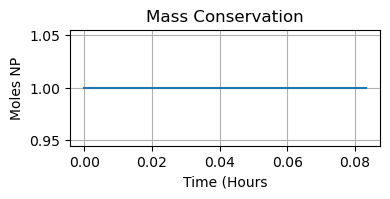

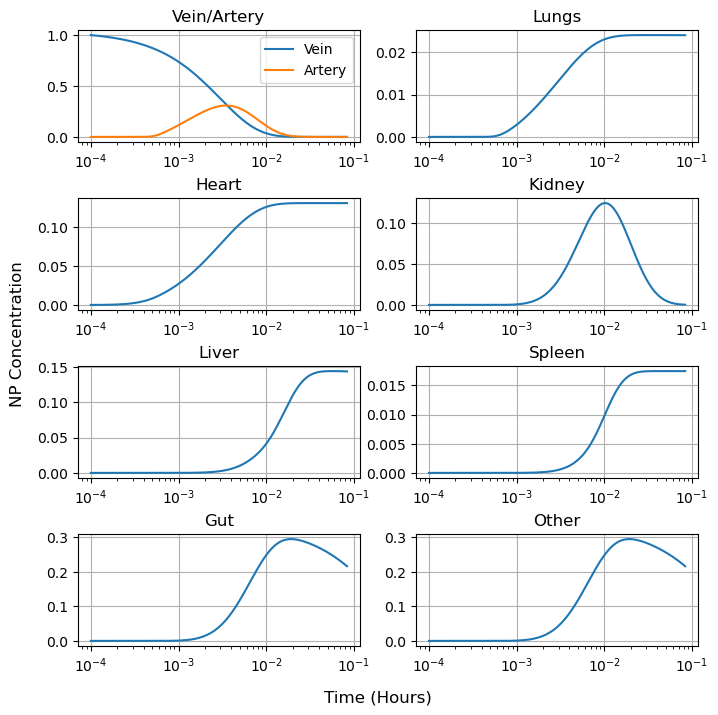

In [16]:
main(K_on[1, :], K_off[1, :])